# BIRCH 
This implementation follows the base birch algorithm implementation found here : T. Zhang, R. Ramakrishnan and M. Livny, “BIRCH: an efficient data clustering method for very large databases” in ACM Sigmod Record, ACM, vol. 25, pp. 103–114.<br>
Also some parts was taken from this easier explanation, here : https://medium.com/@noel.cs21/balanced-iterative-reducing-and-clustering-using-heirachies-birch-5680adffaa58 <br>
## Experimental setup & some notes 
So here we basically implement the basic algorithm of BIRCH for clustering AKA build the CF-Tree after building the tree <br>
we then use agglomerative clustering as the second stage (Global Clustering Phase)<br>
**note**: we try to match the same behaviour as SK-learn, because SK-learn has many options. foe example: we used a fixed interger number for n_cluster <br>
to force SK-learn to use agglomerative clustering<br>
** This notebook has the following **<br>
1- *Utility section*:Some untility functions for printing results and stuff<br>
2- *basic Birch implementation with some comments*<br>
3- *results per dataset*: overall results for each dataset + some commments<br>
........................ Thank you .................................

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, mutual_info_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import kagglehub
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

### utility functions

In [1]:
"""
This function is used to print the different matrics given the true labels and predicted labels.
"""
def print_metrics(X, true_labels_values, predicted_labels, print_res = True):
    if not print_res:
        return {
        "Silhouette": silhouette_score(X, predicted_labels),
        "Adjusted Rand": adjusted_rand_score(true_labels, predicted_labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, predicted_labels),
        "Davies-Bouldin": davies_bouldin_score(X, predicted_labels),
        "Mutual Information": mutual_info_score(true_labels, predicted_labels)
        }
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")

In [11]:
def percentage_similarity(base_array, sklearn_array):
    # Ensure both arrays have the same shape
    if base_array.shape != sklearn_array.shape:
        raise ValueError("Input arrays must have the same shape")
    cnt_sim = 0
    for i,x in enumerate(base_array):
      if x == sklearn_array[i]:
        cnt_sim += 1
    return cnt_sim * 100/ len(base_array)


### BIRCH Base Implementaion

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# helper class which represents the CFs in the BIRCH tree
class CF:
    def __init__(self, point):
        self.n = 1
        self.LS = np.array(point)           # Linear Sum
        self.SS = np.array(point) ** 2      # Squared Sum
        self.centroid = np.array(point)
        self.children = []  # Only used for non-leaf CFs
        self.datapoints = [np.array(point)]
        
    # check if a CF can absorb a new point without vilating the threshold
    def absorb(self, point, threshold):
        new_n = self.n + 1
        new_LS = self.LS + point
        new_SS = self.SS + point ** 2
        new_centroid = new_LS / new_n
        radius = np.sqrt(np.sum((new_SS / new_n) - new_centroid ** 2))
        if radius <= threshold:
            self.n = new_n
            self.LS = new_LS
            self.SS = new_SS
            self.centroid = new_centroid
            self.datapoints.append(point)
            return True
        return False
        
    # this function is used when spliting nodes as we need to merge the CFs 
    # to have one CF that represents the children CFs
    def merge(self, other_cf):
        self.n += other_cf.n
        self.LS += other_cf.LS
        self.SS += other_cf.SS
        self.centroid = self.LS / self.n
        self.datapoints.extend(other_cf.datapoints)

# helper class which represents the nodes in the BIRCH tree
class Node:
    def __init__(self, is_leaf, branching_factor, threshold):
        self.entries = []  # CFs
        self.children = []  # Nodes (if not leaf)
        self.is_leaf = is_leaf
        self.parent = None
        self.next_leaf = None
        self.branching_factor = branching_factor
        self.threshold = threshold

    def find_closest_cf(self, point):
        return min(self.entries, key=lambda cf: np.linalg.norm(cf.centroid - point))
        
    # check branching factor and insert the CF in the node
    def insert_cf(self, new_cf):
        if len(self.entries) < self.branching_factor:
            self.entries.append(new_cf)
            return None
        else:
            return self.split_node(new_cf)

    def split_node(self, new_cf):
        # Select 2 farthest entries with the new CF
        all_cfs = self.entries.copy()
        if new_cf is not None:  # Make sure to handle None for dummy splits when parent is full
            all_cfs.append(new_cf)
            
        # Find the two farthest CFs as seeds
        max_dist = -1
        seed1, seed2 = None, None
        for i in range(len(all_cfs)):
            for j in range(i + 1, len(all_cfs)):
                dist = np.linalg.norm(all_cfs[i].centroid - all_cfs[j].centroid)
                if dist > max_dist:
                    max_dist = dist
                    seed1, seed2 = all_cfs[i], all_cfs[j]

        # Create two new nodes
        node1 = Node(self.is_leaf, self.branching_factor, self.threshold)
        node2 = Node(self.is_leaf, self.branching_factor, self.threshold)
        node1.parent = self.parent
        node2.parent = self.parent

        # Track which CF goes to which node
        node1_cfs = []
        node2_cfs = []
        
        # If this is not a leaf node, track children as well
        child_mapping = {}
        if not self.is_leaf:
            for i, cf in enumerate(self.entries):
                if i < len(self.children):  # Safety check
                    child_mapping[cf] = self.children[i]

        # Distribute CFs between the two new nodes based on distance
        for cf in all_cfs:
            dist1 = np.linalg.norm(cf.centroid - seed1.centroid)
            dist2 = np.linalg.norm(cf.centroid - seed2.centroid)
            if dist1 < dist2:
                node1_cfs.append(cf)
            else:
                node2_cfs.append(cf)
        
        # Set entries for new nodes
        node1.entries = node1_cfs
        node2.entries = node2_cfs
        
        # If this is not a leaf node, redistribute children accordingly
        if not self.is_leaf:
            for cf in node1.entries:
                if cf in child_mapping:
                    child = child_mapping[cf]
                    node1.children.append(child)
                    child.parent = node1
                    
            for cf in node2.entries:
                if cf in child_mapping:
                    child = child_mapping[cf]
                    node2.children.append(child)
                    child.parent = node2

        # Update leaf node chain if this is a leaf
        if self.is_leaf:
            node1.next_leaf = node2
            node2.next_leaf = self.next_leaf

        return node1, node2

    def is_full(self):
        return len(self.entries) >= self.branching_factor

# base birch class
class BaseBirch:
    def __init__(self, threshold=0.5, branching_factor=10):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.root = Node(is_leaf=True, branching_factor=branching_factor, threshold=threshold)
        self.leaf_nodes = [self.root]

    def build_tree(self, X):
        for x in X:
            self.insert_point(np.array(x))

    def insert_point(self, point):
        # Find the leaf node where the nearest leaf-CF is located
        leaf, path = self.find_leaf(self.root, point, [])
        
        # check if leaf node has any CFs, if so find the closest CF
        if leaf.entries: 
            closest_cf = leaf.find_closest_cf(point) 
        else:
            closest_cf = None

        if closest_cf and closest_cf.absorb(point, self.threshold):
            self.update_path(path)
        else:
            # if there is no CF in the leaf add new one and handle the split
            new_cf = CF(point)
            result = leaf.insert_cf(new_cf)
            if result:
                self.handle_split(leaf, result)
            self.update_path(path)
            
    def find_leaf(self, node, point, path):
        path.append(node)
        if node.is_leaf:  # base case: we reach a leaf node
            return node, path
        else:
            closest_cf = node.find_closest_cf(point)
            idx = node.entries.index(closest_cf)
            return self.find_leaf(node.children[idx], point, path)

    def handle_split(self, node, split_nodes):
        node1, node2 = split_nodes
        
        # if root is split, create a new root
        if node == self.root:
            # New root
            new_root = Node(is_leaf=False, branching_factor=self.branching_factor, threshold=self.threshold)
            new_root.entries = [self.create_cf(node1), self.create_cf(node2)]
            new_root.children = [node1, node2]
            node1.parent = node2.parent = new_root
            self.root = new_root
            
            # Update leaf nodes list if we split a leaf root
            if node.is_leaf:
                self.leaf_nodes = [node1, node2]
            return
            
        # non root splitting 
        parent = node.parent
        idx = parent.children.index(node)
        parent.entries.pop(idx)
        parent.children.pop(idx)

        # Add the split nodes to the parent
        parent.entries.append(self.create_cf(node1))
        parent.children.append(node1)
        node1.parent = parent
        
        parent.entries.append(self.create_cf(node2))
        parent.children.append(node2)
        node2.parent = parent
        
        # Update the leaf_nodes list if we split a leaf node
        if node.is_leaf:
            idx = self.leaf_nodes.index(node) if node in self.leaf_nodes else -1
            if idx != -1:
                self.leaf_nodes.pop(idx)
                self.leaf_nodes.insert(idx, node1)
                self.leaf_nodes.insert(idx + 1, node2)

        # Check if parent needs to be split (recursive)
        if parent.is_full():
            split = parent.split_node(None)  # force split with dummy
            self.handle_split(parent, split)
            
    # wrapper to create CF and merge with others
    def create_cf(self, node):
        if not node.entries:
            raise ValueError("Cannot create CF from node with no entries")
            
        cf = CF(np.zeros_like(node.entries[0].centroid))
        for entry in node.entries:
            cf.merge(entry)
        return cf

    def update_path(self, path):
        for node in reversed(path[:-1]):  # skip the leaf
            for i, cf in enumerate(node.entries):
                if i < len(node.children):  # Safety check
                    child = node.children[i]
                    new_cf = self.create_cf(child)
                    node.entries[i] = new_cf

    def get_clusters(self, n_clusters=2):
        cf_centroids = []
        cf_to_label = {}
        data_points = []
        data_labels = []

        # Step 1: Collect all CF centroids from leaf nodes
        leaf_cfs = []
        for leaf in self._get_all_leaf_nodes():
            for cf in leaf.entries:
                if len(cf.datapoints) > 0:
                    cf_centroids.append(cf.centroid)
                    leaf_cfs.append(cf)

        # Step 2: Apply clustering on CF centroids
        if len(cf_centroids) < n_clusters:
            n_clusters = len(cf_centroids)
            print(f"Number of clusters reduced to {n_clusters} due to insufficient CFs.")

        if n_clusters > 1 and len(cf_centroids) > 1:
            clustering = AgglomerativeClustering(n_clusters=n_clusters)
            cf_labels = clustering.fit_predict(cf_centroids)
        else:
            cf_labels = [0] * len(cf_centroids)

        # Step 3: Assign each point the label of its CF
        for i, cf in enumerate(leaf_cfs):
            for point in cf.datapoints:
                data_points.append(point)
                data_labels.append(cf_labels[i])

        return np.array(data_labels)

    # BFS to get the leaf nodes when extracting clusters labels
    def _get_all_leaf_nodes(self):
        result = []
        queue = [self.root]
        while queue:
            node = queue.pop(0)  # Use pop(0) for FIFO queue behavior
            if node.is_leaf:
                result.append(node)
            else:
                queue.extend(node.children)
        return result

### Comparison running section (Dataset-based)
To see justification and why those feature is encoded or either selected please refere to the paper and comparison.ipynb

#### Iris Dataset

In [72]:
# default Birch Hyperparameters
BRANCH_FACTOR = 10
THRESHOLD = 0.5
IRIS_N_CLUSTERS = 3
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

####################### Base BIRCH #######################
start_time = time.time()
base_birch = BaseBirch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR)
base_birch.build_tree(X_iris)
labels_base_iris = base_birch.get_clusters(n_clusters=IRIS_N_CLUSTERS)
#print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_base_iris)

############################ sklearn BIRCH #######################
start_time = time.time()
sk_birch = Birch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR, n_clusters=IRIS_N_CLUSTERS)
labels_sklearn_iris = sk_birch.fit_predict(X_iris)
#print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_sklearn_iris)
print(f"percentage_similarity: {percentage_similarity(labels_base_iris, labels_sklearn_iris)}%")

Execution time (base): 0.039034128189086914 seconds
-------------------------------------------------------------------
Silhouette score: 0.3081
Adjusted Rand score: 0.6250
Calinski-Harabasz score: 289.6472
Davies-Bouldin score: 1.3795
Mutual Information score: 0.7548

Execution time (sklearn): 0.016440868377685547 seconds
-------------------------------------------------------------------
Silhouette score: 0.5017
Adjusted Rand score: 0.6096
Calinski-Harabasz score: 457.5418
Davies-Bouldin score: 0.6263
Mutual Information score: 0.7412
percentage_similarity: 78.66666666666667%


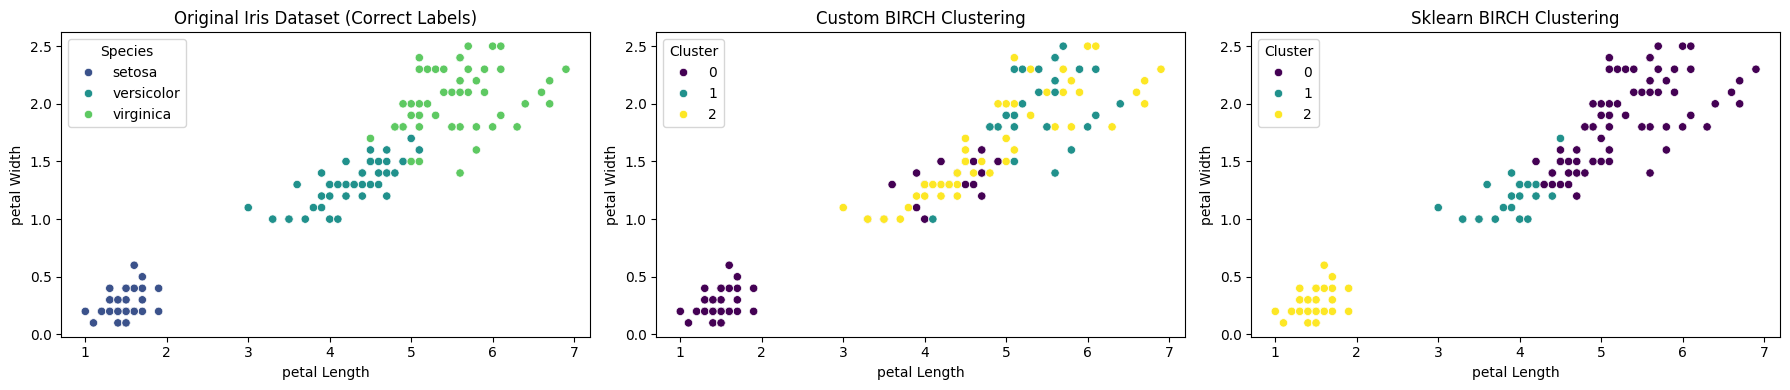

In [69]:

# Create a figure with three subplots
clusters_colors = "viridis"
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette=clusters_colors, ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("petal Length")
axes[0].set_ylabel("petal Width")
axes[0].legend(title="Species")

# Plot 2: Custom BIRCH Labels (labels_base_iris)
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_base_iris, palette=clusters_colors, ax=axes[1])
axes[1].set_title("Custom BIRCH Clustering")
axes[1].set_xlabel("petal Length")
axes[1].set_ylabel("petal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn BIRCH Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_sklearn_iris, palette=clusters_colors, ax=axes[2])
axes[2].set_title("Sklearn BIRCH Clustering")
axes[2].set_xlabel("petal Length")
axes[2].set_ylabel("petal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

0, 1 , 2 >> represents clusters that can me mapped again to the original classes for Iris dataset. but no need to do this since we just care about clustering quality.

### AI Dataset


In [ ]:
AI_N_CLUSTERS = 3
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()

print("AI Global Index")
print("####################### Base BIRCH #######################")
base_birch = BaseBirch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR)
start_time = time.time()
base_birch.build_tree(X_ai)
labels_base_ai = base_birch.get_clusters(n_clusters=AI_N_CLUSTERS)

print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_base_ai)
#print(labels_base_ai)
print('############################ sklearn BIRCH #######################')
start_time = time.time()
sk_birch = Birch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR, n_clusters=AI_N_CLUSTERS)
labels_sklearn_ai = sk_birch.fit_predict(X_ai)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_sklearn_ai)
#print(labels_sklearn_ai)
print(f"percentage_similarity: {percentage_similarity(labels_base_ai, labels_sklearn_ai)}%")

AI Global Index
####################### Base BIRCH #######################
Execution time (base): 0.04214000701904297 seconds
-------------------------------------------------------------------
Silhouette score: 0.1831
Adjusted Rand score: 0.0744
Calinski-Harabasz score: 11.9954
Davies-Bouldin score: 1.7671
Mutual Information score: 0.1201
############################ sklearn BIRCH #######################

Execution time (sklearn): 0.018773555755615234 seconds
-------------------------------------------------------------------
Silhouette score: 0.3347
Adjusted Rand score: 0.0925
Calinski-Harabasz score: 26.6259
Davies-Bouldin score: 0.8342
Mutual Information score: 0.1274
percentage_similarity: 74.19354838709677%


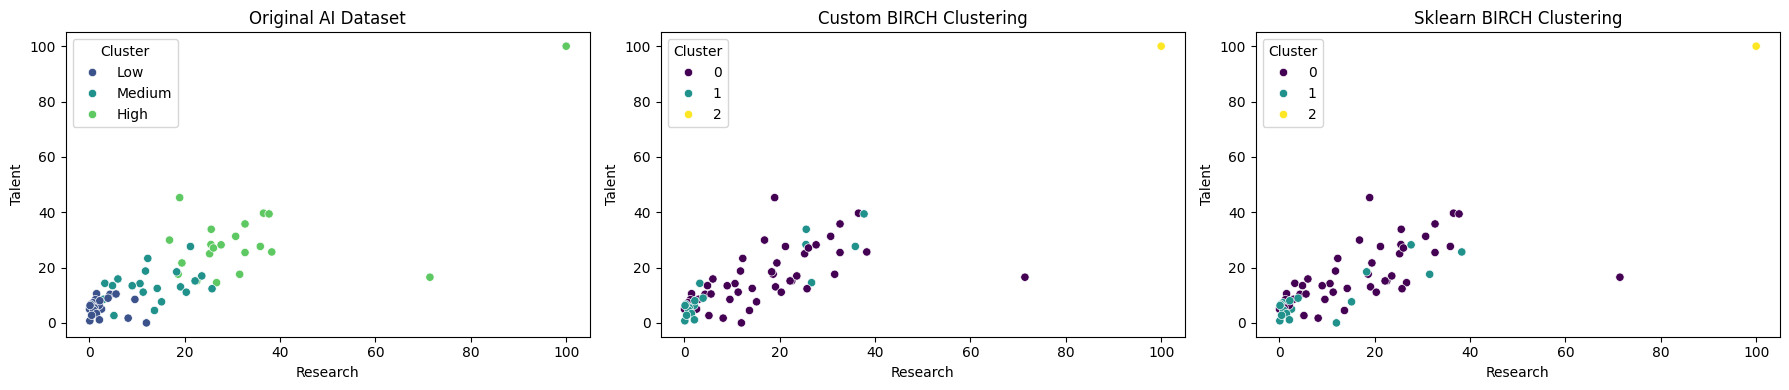

In [77]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom BIRCH Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom BIRCH Clustering")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn BIRCH Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn BIRCH Clustering")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

0, 1 , 2 >> represents clusters that can me mapped again to the original classes for Iris dataset. but no need to do this since we just care about clustering quality.

## Earthquakes Dataset

In [ ]:
EARTHQUACKE_N_CLUSTERS = 4
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()

print("Global Earthquake Data")
print("####################### Base BIRCH #######################")
start_time = time.time()
base_birch = BaseBirch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR)
base_birch.build_tree(X_earth)
labels_base_earth = base_birch.get_clusters(n_clusters=EARTHQUACKE_N_CLUSTERS)

print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth)
#print(labels_base_earth)
print('############################ sklearn BIRCH #######################')
sk_birch = Birch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR, n_clusters=EARTHQUACKE_N_CLUSTERS)
start_time = time.time()
labels_sklearn_earth = sk_birch.fit_predict(X_earth)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth)
#print(labels_sklearn_earth)

Global Earthquake Data
####################### Base BIRCH #######################


C:\Users\hcore\AppData\Local\Temp\ipykernel_25820\1973789795.py:20: RuntimeWarning: invalid value encountered in sqrt
  radius = np.sqrt(np.sum((new_SS / new_n) - new_centroid ** 2))


Execution time (base): 0.3472881317138672 seconds
-------------------------------------------------------------------
Silhouette score: -0.5509
Adjusted Rand score: -0.0247
Calinski-Harabasz score: 0.3544
Davies-Bouldin score: 5.1574
Mutual Information score: 0.0011
############################ sklearn BIRCH #######################

Execution time (sklearn): 0.05363202095031738 seconds
-------------------------------------------------------------------
Silhouette score: 0.9486
Adjusted Rand score: -0.0247
Calinski-Harabasz score: 36082.4435
Davies-Bouldin score: 0.2272
Mutual Information score: 0.0011


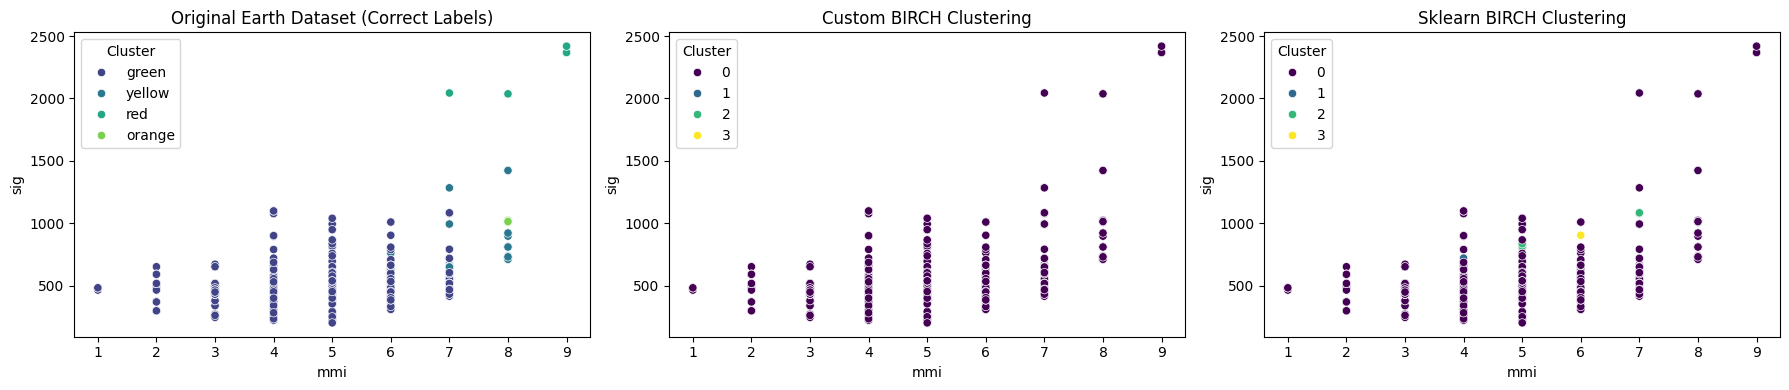

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("sig")
axes[0].legend(title="Cluster")

# Plot 2: Custom BIRCH Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom BIRCH Clustering")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("sig")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn BIRCH Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn BIRCH Clustering")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("sig")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Q4 Answer

In [75]:
EARTHQUACKE_N_CLUSTERS = 4
from sklearn.feature_selection import SelectKBest, mutual_info_classif

encoder = OrdinalEncoder()

alert_encoded = encoder.fit_transform(earthquakes["alert"].to_frame())
selector = SelectKBest(score_func=mutual_info_classif, k=5)

X_earth = selector.fit_transform(earthquakes_filtered, alert_encoded.ravel())
k_earth = 4

print("Global Earthquake Data")
print("####################### Base BIRCH #######################")
start_time = time.time()
base_birch = BaseBirch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR)
base_birch.build_tree(X_earth)
labels_base_earth = base_birch.get_clusters(n_clusters=EARTHQUACKE_N_CLUSTERS)

print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth)
#print(labels_base_earth)
print('############################ sklearn BIRCH #######################')
sk_birch = Birch(threshold=THRESHOLD, branching_factor=BRANCH_FACTOR, n_clusters=EARTHQUACKE_N_CLUSTERS)
start_time = time.time()
labels_sklearn_earth = sk_birch.fit_predict(X_earth)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth)
#print(labels_sklearn_earth)

Global Earthquake Data
####################### Base BIRCH #######################
Execution time (base): 0.5273432731628418 seconds
-------------------------------------------------------------------
Silhouette score: -0.0336
Adjusted Rand score: 0.0159
Calinski-Harabasz score: 2.4417
Davies-Bouldin score: 14.5282
Mutual Information score: 0.0038
############################ sklearn BIRCH #######################

Execution time (sklearn): 0.08165860176086426 seconds
-------------------------------------------------------------------
Silhouette score: 0.5579
Adjusted Rand score: 0.0787
Calinski-Harabasz score: 1238.3075
Davies-Bouldin score: 0.5980
Mutual Information score: 0.1057


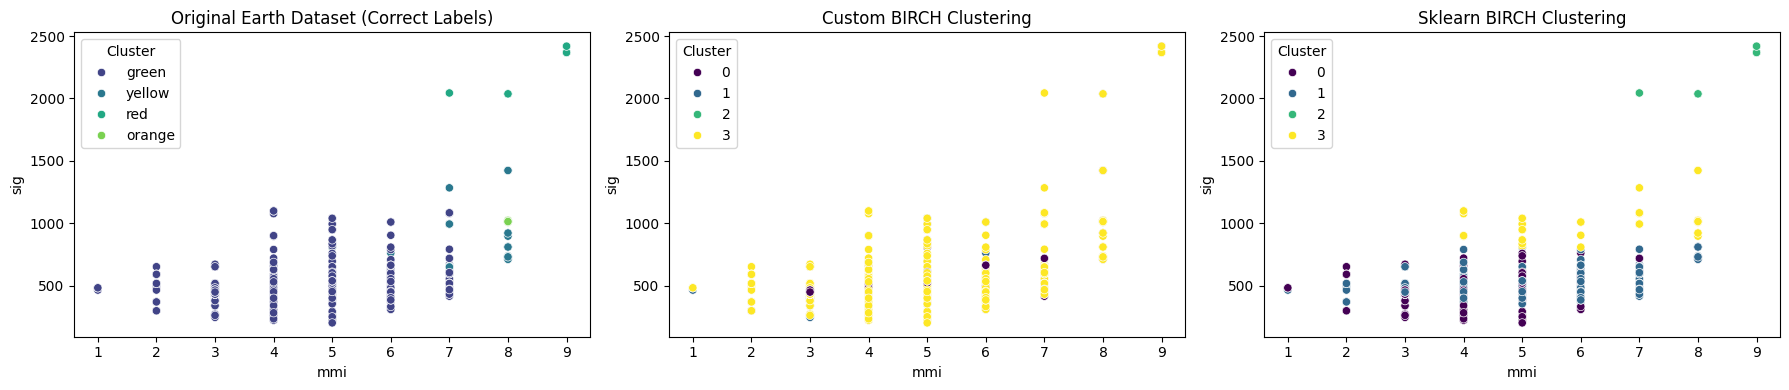

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("sig")
axes[0].legend(title="Cluster")

# Plot 2: Custom BIRCH Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom BIRCH Clustering")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("sig")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn BIRCH Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn BIRCH Clustering")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("sig")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Generating a comprehensive figure


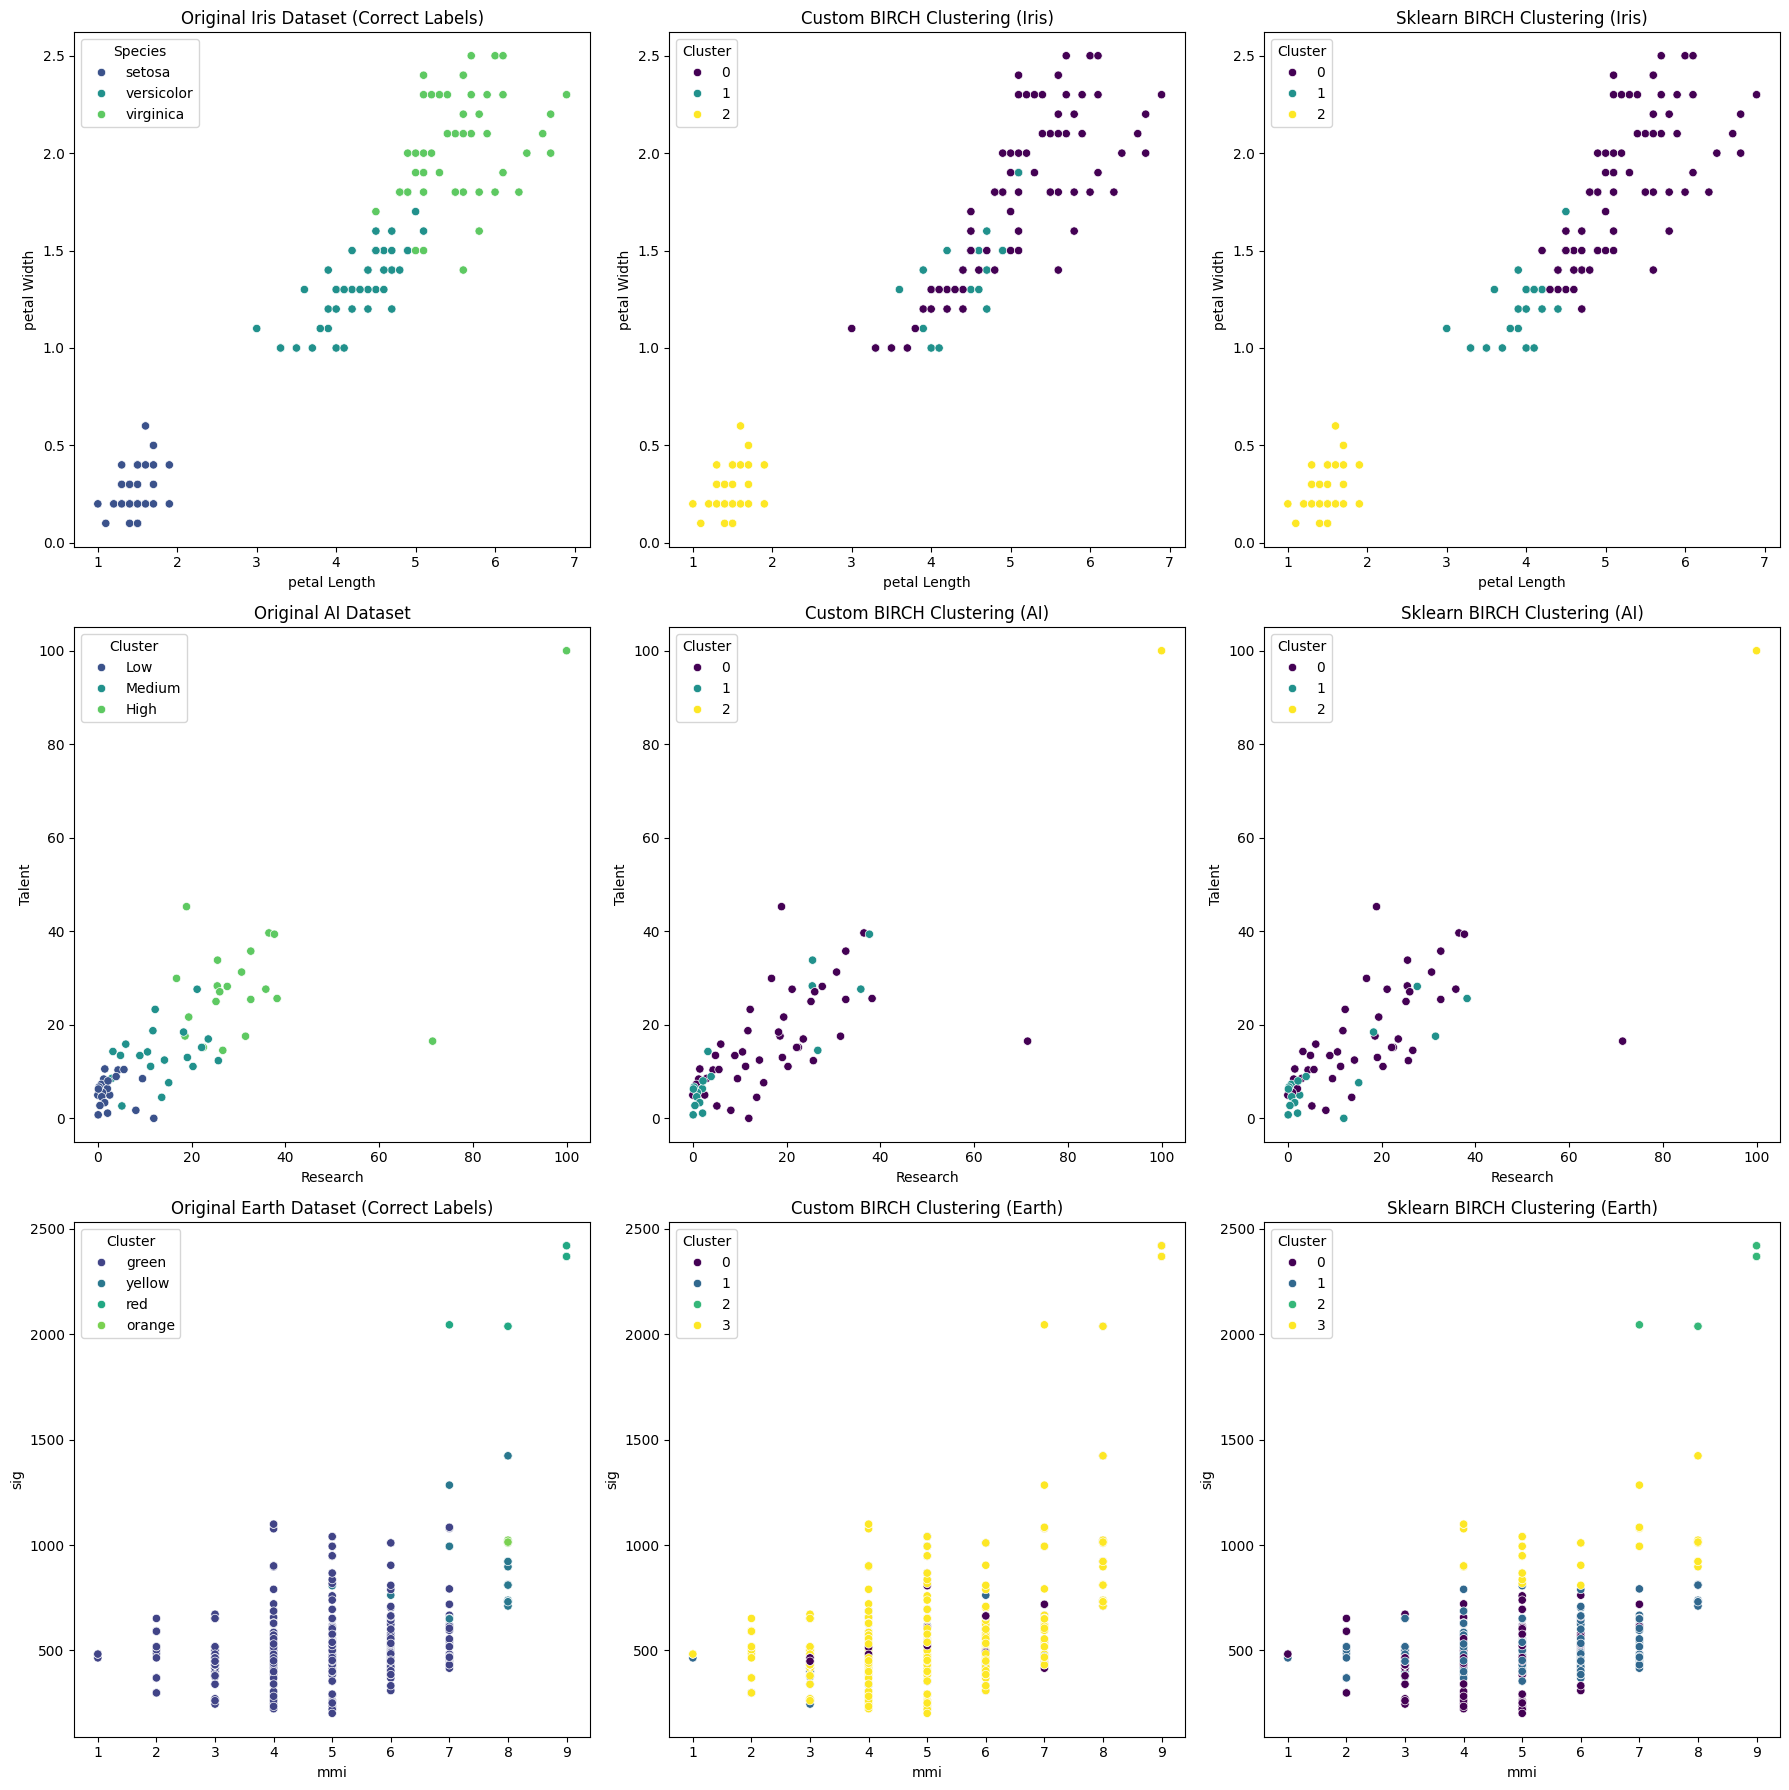

In [78]:
clusters_colors = "viridis"
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # 3 rows, 3 columns

# Row 1: Iris Dataset
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette=clusters_colors, ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("petal Length")
axes[0][0].set_ylabel("petal Width")
axes[0][0].legend(title="Species")

sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_base_iris, palette=clusters_colors, ax=axes[0][1])
axes[0][1].set_title("Custom BIRCH Clustering (Iris)")
axes[0][1].set_xlabel("petal Length")
axes[0][1].set_ylabel("petal Width")
axes[0][1].legend(title="Cluster")

sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_sklearn_iris, palette=clusters_colors, ax=axes[0][2])
axes[0][2].set_title("Sklearn BIRCH Clustering (Iris)")
axes[0][2].set_xlabel("petal Length")
axes[0][2].set_ylabel("petal Width")
axes[0][2].legend(title="Cluster")

# Row 2: AI Dataset
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette=clusters_colors, ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette=clusters_colors, ax=axes[1][1])
axes[1][1].set_title("Custom BIRCH Clustering (AI)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette=clusters_colors, ax=axes[1][2])
axes[1][2].set_title("Sklearn BIRCH Clustering (AI)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")

# Row 3: Earthquake Dataset
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette=clusters_colors, ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("sig")
axes[2][0].legend(title="Cluster")

sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette=clusters_colors, ax=axes[2][1])
axes[2][1].set_title("Custom BIRCH Clustering (Earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("sig")
axes[2][1].legend(title="Cluster")

sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette=clusters_colors, ax=axes[2][2])
axes[2][2].set_title("Sklearn BIRCH Clustering (Earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("sig")
axes[2][2].legend(title="Cluster")

plt.tight_layout()
plt.show()
